# Data preprocessing

In [ ]:
# Uncomment if lib is not installed
# !pip install tensorly

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# IMPORT LIBS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl
from scipy.interpolate import interp1d

## Own functions

In [8]:
# FUNC TO INTERPOLATE DATA
def interpolate_matrix(matrix, target_cols):
    matrix = matrix.values  # df to np
    
    rows, cols = matrix.shape
    
    current_cols = np.arange(cols)
    target_cols_indices = np.linspace(0, cols-1, target_cols)
    
    # Interpolate each row
    interpolated_matrix = np.zeros((rows, target_cols))
    for i in range(rows):
        f = interp1d(current_cols, matrix[i], kind='linear', fill_value='extrapolate')
        interpolated_matrix[i] = f(target_cols_indices)
    
    return interpolated_matrix

## Data reading and tensor construction

In [ ]:
# IMPORT DATA
pat_list = ['SARK018', 'SARK019', 'SARK017', 'SARK021', 'SARK041', 'SARK011', 'SARK027', 
            'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK052', 'SARK059']

file_path = 'TCR_sequencing_all_samples_adjusted_20240508.xlsx'

seqs_to_keep = 100 #Number of most abundant sequences to keep
low_tensor_size = 8 #Number of time steps for the small tensor
high_tensor_size = 20 #Number of time steps for the large tensor

# Define matrices list
low_matrices = []
high_matrices = []

# Load the Excel file
for i, pat in enumerate(pat_list):
    sheet_index = (i+1)*2-2
    tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl') # COUNTS
    tcr_df_freq = pd.read_excel(file_path, sheet_name=sheet_index+1, engine='openpyxl') # FREQS

    # Remove rows where 'CDR3.amino.acid.sequence' is NaN
    tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])
    tcr_df_freq = tcr_df_freq.dropna(subset=['CDR3.amino.acid.sequence'])

    # Select columns containing '_S'
    tcr_counts = tcr_df.filter(regex='_S').copy()
    tcr_freq = tcr_df_freq.filter(regex='_S').copy()

    # Rename columns by extracting the part after '_'
    tcr_counts.columns = [col.split('_')[1] for col in tcr_counts.columns]
    tcr_freq.columns = [col.split('_')[1] for col in tcr_freq.columns]

    # Sort time steps
    tcr_counts = tcr_counts[sorted(tcr_counts.columns, key=lambda x: int(x[1:]))]
    tcr_freq = tcr_freq[sorted(tcr_freq.columns, key=lambda x: int(x[1:]))]

    # Check if there are missing values
    # print(tcr_counts.isna().sum())
    # print(tcr_freq.isna().sum())
    # print(tcr_counts.shape)
    # print(tcr_freq.shape)

    # Replace missing values with a 0 if the freq data has a 0
    tcr_counts = tcr_counts.where(~(tcr_counts.isna() & (tcr_freq == 0)), 0)

    # Check nan replacement
    # print(tcr_counts.isna().sum())

    # Save into tensor. Order by descending order of counts in the first time col. 
    # Mergesort to keep order in case of empate. 
    # Keep 100 highest sequences with most counts
    tcr_to_tensor = tcr_counts.sort_values(by=tcr_counts.columns[0], ascending=False, kind="mergesort").head(seqs_to_keep)
    
    # Interpolate data to ensure all patients have same time step
    low_data_interp = interpolate_matrix(tcr_to_tensor, low_tensor_size)
    high_data_interp = interpolate_matrix(tcr_to_tensor, high_tensor_size)

    # Add to matrices list
    low_matrices.append(low_data_interp)
    high_matrices.append(high_data_interp)

# Build tensors (numpy tensor)
low_tensor = np.stack(low_matrices, axis=-1)
high_tensor = np.stack(high_matrices, axis=-1)

# Check sizes
print(low_tensor.shape)
print(high_tensor.shape)

# Convert to tensorly tensors (num_seqs, time, num_patients)
low_tensor = tl.tensor(low_tensor)
high_tensor = tl.tensor(high_tensor)


(100, 8, 13)
(100, 20, 13)


## Tensor preprocessing

### Normalisation
Done in each dimension independently to keep multilinear nature of the data.

Following recommendations of Stegeman - Erfurt Parafac talk for 3-way data. But not normalisation in Mode 3 because we are interested in time-dependent trends.

<!-- Hybrid approach to ensure that decomposition reveals structure without removing biologically meaningful variation:
 1. Log Transformation (Variance Stabilization): 
    - Reduces skewness while keeping biologically meaningful relative differences.
 2. Robust Scaling Across Sequences (Instead of Z-score): 
    - Preserves sequence-level biological meaning while reducing dominance of extremely high-count sequences.
    - Uses Median & IQR (Interquartile Range) instead of Mean & Std to avoid overcorrection.
 3. Z-score Across Patients
    - Ensures comparability across individuals by removing patient-specific magnitude biases. -->

In [ ]:
# Normalization functions

# We should NOT center across Mode 3 (time) because we are interested in time-dependent trends in immune responses

def log_transform(tensor):
    """ Apply log transformation to stabilize variance. """
    return tl.log(tensor + 1e-6)  # Avoid log(0) issues

def center_across_subjects(tensor):
    """ Centering across subjects (Mode 1) to remove patient-level biases. """
    mean_subjects = tl.mean(tensor, axis=0, keepdims=True)
    return tensor - mean_subjects

def normalize_within_sequences(tensor):
    """ Normalize within sequences (Mode 2) to balance different sequences. """
    tensor_np = tl.to_numpy(tensor)
    std_sequences = np.std(tensor_np, axis=1, keepdims=True) + 1e-8  # Avoid division by zero
    return tl.tensor(tensor_np / std_sequences)

def preprocess_for_tensor_decomposition(tensor):
    """
    Preprocessing steps based on CP and Tucker decomposition requirements.
    1. Log Transform
    2. Center Across Subjects (Mode 1)
    3. Normalize Within Sequences (Mode 2)
    
    Args:
        tensor: TensorLy tensor (shape: sequences x time x patients)
    
    Returns:
        Normalized tensor
    """
    tensor = log_transform(tensor)
    tensor = center_across_subjects(tensor)  # Ensures subject-level comparability
    tensor = normalize_within_sequences(tensor)  # Ensures sequence-level comparability
    return tensor

# Apply normalization
low_tensor_norm = preprocess_for_tensor_decomposition(low_tensor)
high_tensor_norm = preprocess_for_tensor_decomposition(high_tensor)

# # | Normalization Method                      | Why Applied?                                                            |
# # |-------------------------------------------|---------------------------------------------------------------------------|
# # | Log Transformation                        | Prevents extreme values from dominating decomposition while preserving    |
# # |                                           |     rank order of counts. Stabilizes variance and ensures comparability.  |
# # | Centering Across Subjects (Mode 1)        | Removes individual patient biases, ensuring that decomposition captures   |
# # |                                           |     sequence-level and time-dependent patterns rather than individual     |
# # |                                           |     magnitude differences.                                                |
# # | Normalizing Within Sequences (Mode 2)     | Ensures all sequences contribute meaningfully to decomposition by         |
# # |                                           |     reducing dominance of high-count sequences without erasing biological |
# # |                                           |     differences. Uses robust scaling (median-IQR) instead of Z-score.     |



# # | Normalization Method                      | Why Not Applied?                                                         |
# # |-------------------------------------------|---------------------------------------------------------------------------|
# # | Min-Max Scaling                           | CP and Tucker decompositions rely on relative differences. Min-Max        |
# # |                                           |     scaling compresses values into [0,1], reducing variability and        |
# # |                                           |     possibly removing important patterns.                                 |
# # | Mean-Centering Across Time (Mode 3)       | Would remove meaningful biological trends, forcing all time-series to     |
# # |                                           |     oscillate around zero. This distorts immune response progression.     |
# # | Normalize by Patient Total (axis=(0,1))   | Would scale all patient values to the same total count. While it ensures  |
# # |                                           |     comparability, it removes magnitude differences that may be           |
# # |                                           |     informative for decomposition.                                        |
# # | Z-score Across Time (axis=1)              | Time trends are already captured well in the interpolated data. Applying  |
# # |                                           |     Z-score across time may distort meaningful time-series signals.       |
# # | Z-score Across Sequences (axis=0)         | Would remove absolute sequence magnitude differences, which may be        |
# # |                                           |     biologically meaningful. Instead, robust scaling (median-IQR) was     |
# # |                                           |     used to prevent extreme values from dominating while preserving       |
# # |                                           |     relative importance.                                                  |

In [27]:
# # Functions for normalisation

# def tensorly_std(tensor, axis=None, keepdims=False):
#     """ Compute standard deviation manually in TensorLy. """
#     mean = tl.mean(tensor, axis=axis, keepdims=True)
#     variance = tl.mean((tensor - mean) ** 2, axis=axis, keepdims=keepdims)  # Variance formula
#     return tl.sqrt(variance + 1e-8)  # Add small constant to prevent sqrt(0)

# def log_transform(tensor):
#     """ Apply log transformation to stabilize variance. """
#     return tl.log(tensor + 1e-6)  # Avoid log(0) errors

# def zscore_across_patients(tensor):
#     """ Apply Z-score normalization across patients (axis=2). """
#     mean = tl.mean(tensor, axis=2, keepdims=True)
#     std = tensorly_std(tensor, axis=2, keepdims=True)
#     return (tensor - mean) / std

# def zscore_across_sequences(tensor):
#     """ Apply Z-score normalization across sequences (axis=0). """
#     mean = tl.mean(tensor, axis=0, keepdims=True)
#     std = tensorly_std(tensor, axis=0, keepdims=True)
#     return (tensor - mean) / std

# def preprocess_for_tensor_decomposition(tensor, normalize_sequences=False):
#     """
#     Complete normalization pipeline for tensor decomposition.
#     - Applies log transformation
#     - Normalizes across patients (Z-score)
#     - (Optional) Normalizes across sequences (Z-score)
    
#     Args:
#         tensor: TensorLy tensor (shape: sequences x time x patients)
#         normalize_sequences (bool): Whether to apply Z-score across sequences.
        
#     Returns:
#         Normalized tensor
#     """
#     tensor = log_transform(tensor)  # Step 1: Log transform
#     tensor = zscore_across_patients(tensor)  # Step 2: Normalize across patients
#     if normalize_sequences:
#         tensor = zscore_across_sequences(tensor)  # Step 3 (Optional): Normalize across sequences
#     return tensor


# # | Normalization Method                      | Why Not Used?                                                             |
# # |-------------------------------------------|---------------------------------------------------------------------------|
# # | Min-Max Scaling                           | Tensor decomposition techniques like CP or Tucker rely on relative        |
# # |                                           |     differences. Min-Max scaling compresses values into [0,1], reducing   |
# # |                                           |     variability and possibly removing important patterns.                 |
# # | Mean-Centering Across Time (axis=1)       | Unnecessary because time-series patterns are already preserved through    |
# # |                                           |     interpolation. Mean-centering would force all time-series to oscillate| 
# # |                                           |     around zero, which is not needed for decomposition.                   |
# # | Normalize by Patient Total (axis=(0,1))   | This would scale all patient values to the same total count. While it     |
# # |                                           |     ensures comparability, it removes magnitude differences that may be   |
# # |                                           |     informative for decomposition.                                        |
# # | Z-score Across Time (axis=1)              | Time trends are already captured well in the interpolated data. Applying  |
# # |                                           |     Z-score across time may distort meaningful time-series signals.       |

# low_tensor_norm = preprocess_for_tensor_decomposition(low_tensor,normalize_sequences=True)
# high_tensor_norm = preprocess_for_tensor_decomposition(high_tensor,normalize_sequences=True)

#### Plots to check normalisation

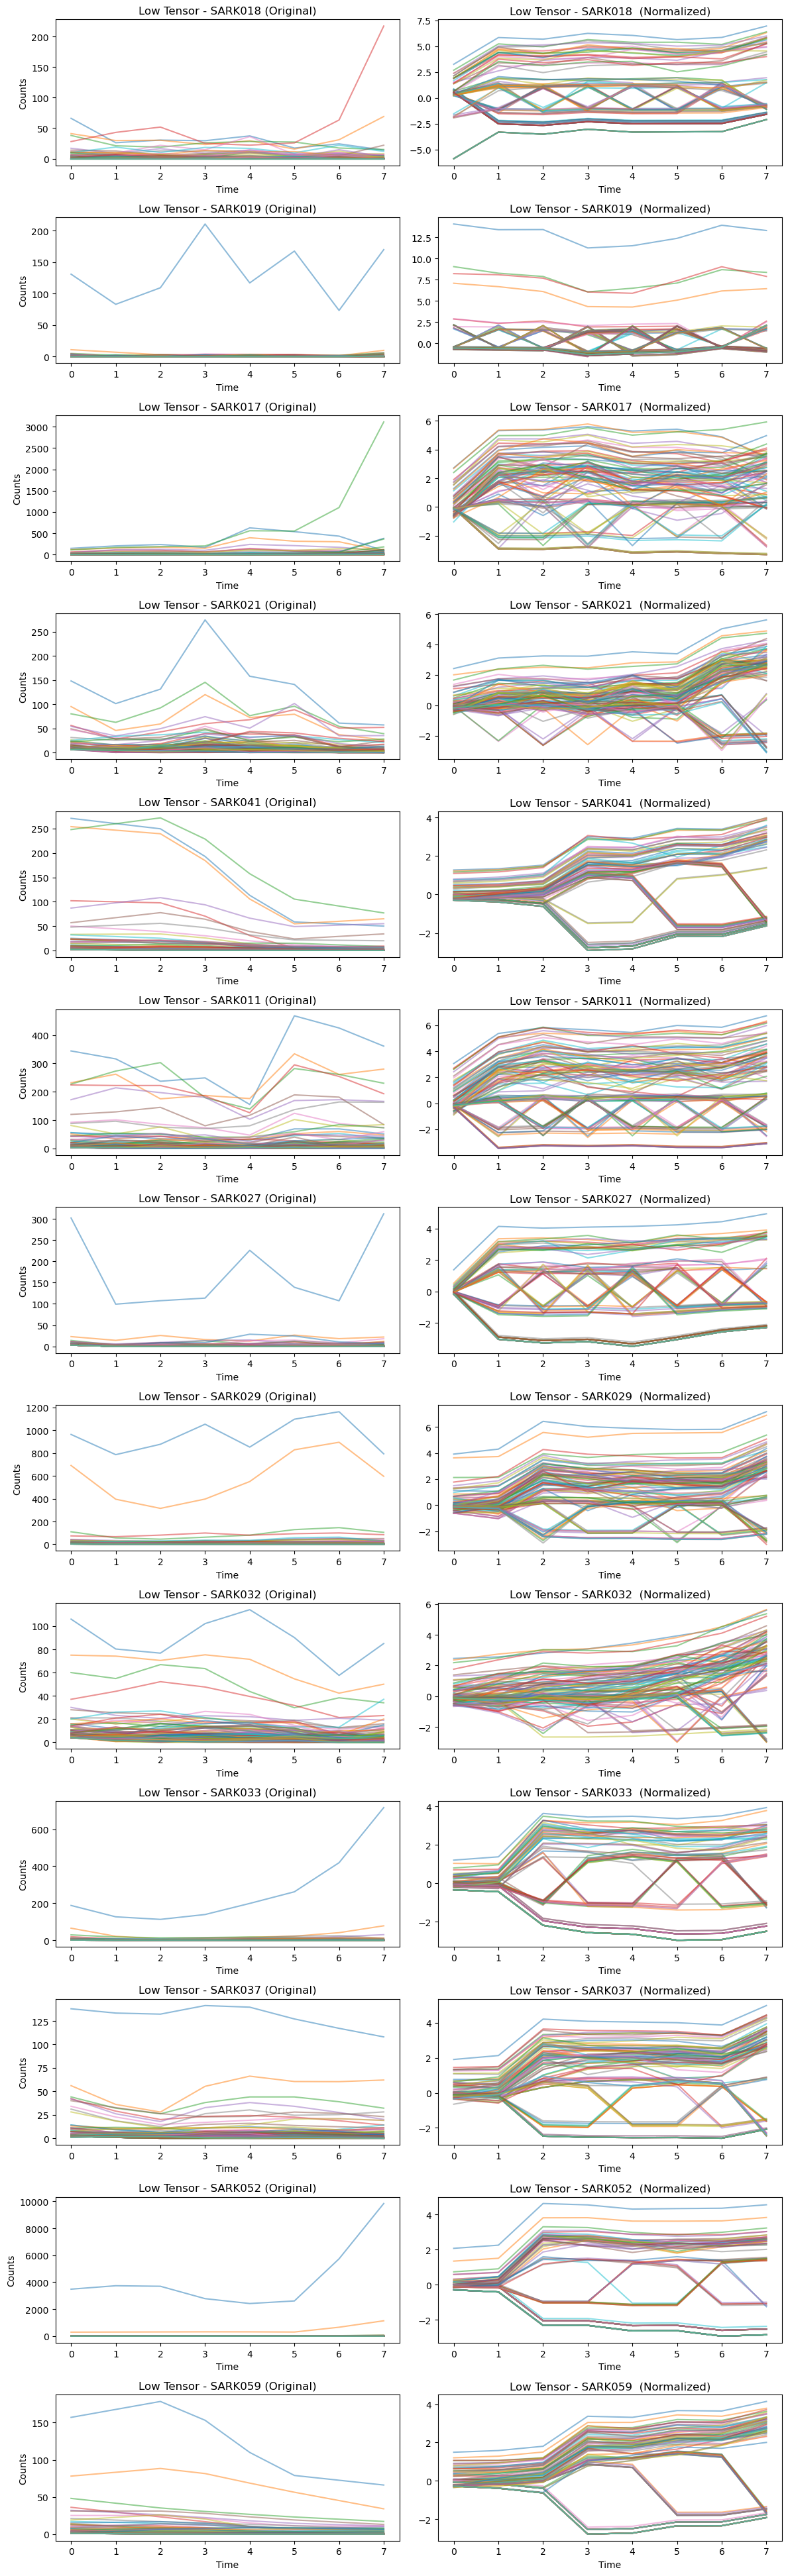

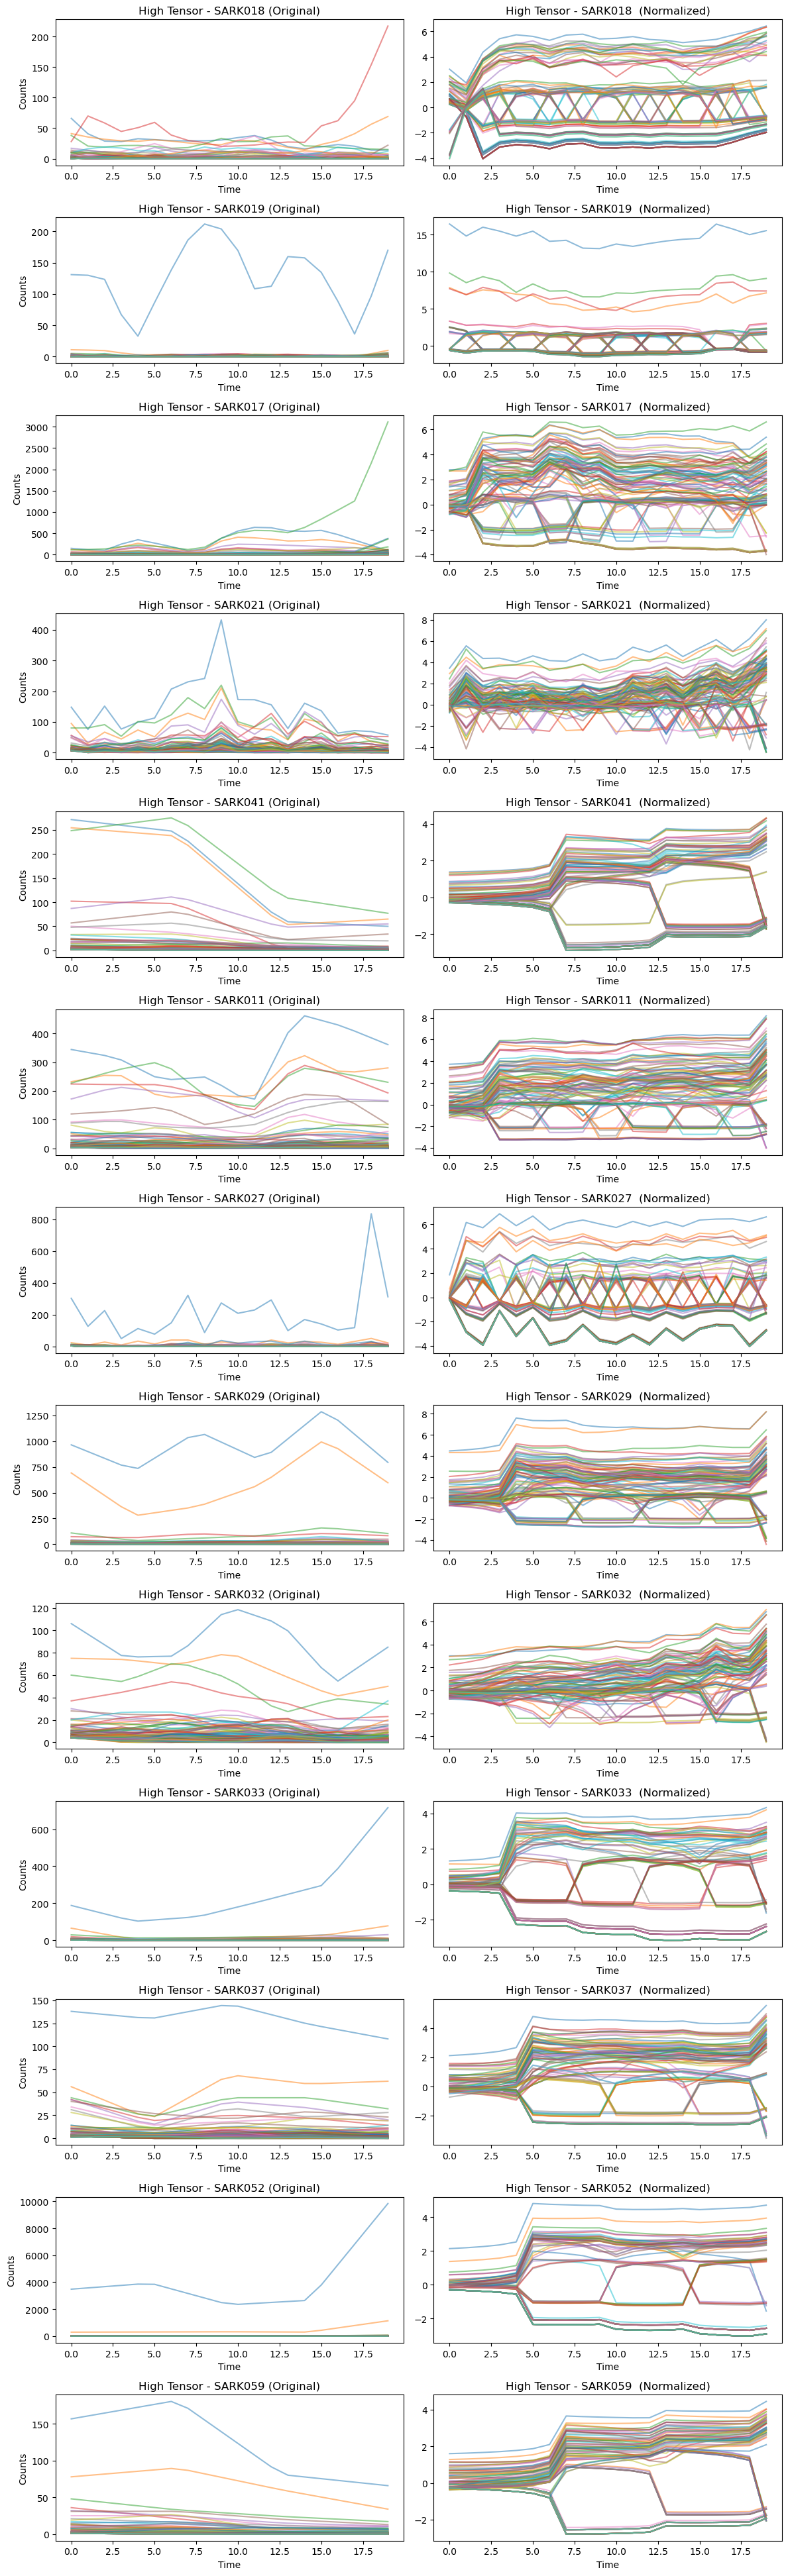

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor_normalization(original_tensor, normalized_tensor, title_prefix):
    """
    Function to plot the original vs normalized tensor for all patients.

    Args:
        original_tensor (numpy array): Shape (num_sequences, num_time, num_patients)
        normalized_tensor (numpy array): Shape (num_sequences, num_time, num_patients)
        title_prefix (str): Prefix for plot titles (e.g., "Low Tensor", "High Tensor")
    """
    num_sequences, num_time, num_patients = original_tensor.shape
    
    # Create subplots: Each row is a patient, columns are (Original | Normalized)
    fig, axes = plt.subplots(num_patients, 2, figsize=(12, num_patients * 3))

    for i, pat in enumerate(pat_list):
        # Extract data for current patient (across sequences and time)
        original_data = original_tensor[:, :, i]  # (num_sequences, num_time)
        normalized_data = normalized_tensor[:, :, i]

        # Original tensor plot
        ax1 = axes[i, 0] if num_patients > 1 else axes[0]
        ax1.plot(original_data.T, alpha=0.5)  # Transpose for time on x-axis
        ax1.set_title(f"{title_prefix} - {pat} (Original)")
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Counts")

        # Normalized tensor plot
        ax2 = axes[i, 1] if num_patients > 1 else axes[1]
        ax2.plot(normalized_data.T, alpha=0.5)
        ax2.set_title(f"{title_prefix} - {pat}  (Normalized)")
        ax2.set_xlabel("Time")

    fig.tight_layout()
    plt.show()

# Convert TensorLy tensors to NumPy if needed (uncomment if necessary)
# low_tensor_np = tl.to_numpy(low_tensor)
# low_tensor_norm_np = tl.to_numpy(low_tensor_norm)
# high_tensor_np = tl.to_numpy(high_tensor)
# high_tensor_norm_np = tl.to_numpy(high_tensor_norm)

# Plot Low Tensor (Original vs. Normalized)
plot_tensor_normalization(low_tensor, low_tensor_norm, "Low Tensor")

# Plot High Tensor (Original vs. Normalized)
plot_tensor_normalization(high_tensor, high_tensor_norm, "High Tensor")


## Save tensor to disk

In [29]:
# Convert TensorLy tensors to NumPy arrays
low_tensor_np = tl.to_numpy(low_tensor)
low_tensor_norm_np = tl.to_numpy(low_tensor_norm)
high_tensor_np = tl.to_numpy(high_tensor)
high_tensor_norm_np = tl.to_numpy(high_tensor_norm)

# Save tensors as .npy files
np.save("low_tensor.npy", low_tensor_np)
np.save("low_tensor_norm.npy", low_tensor_norm_np)
np.save("high_tensor.npy", high_tensor_np)
np.save("high_tensor_norm.npy", high_tensor_norm_np)

print("Tensors saved successfully as .npy files!")

Tensors saved successfully as .npy files!
